In [44]:
from glob import glob
import os
from pathlib import Path
from enum import Enum
import json
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [45]:
DEPENDENCIES_BY_AUTOMATON = '../experiments/find-dependencies/by-automaton/'
DEPENDENCIES_BY_FORMULA = '../experiments/find-dependencies/by-formula/'

# Load Experiment Results

In [46]:
def get_benchmark_name(idx):
    path = "../tools/scripts/benchmarks/{}.txt".format(idx)
    with open(path, 'r') as file:
        name = file.readline().replace("\n", "")
    return name
print(get_benchmark_name(2))

EnemeyModule


In [47]:
class Status(Enum):
    ERROR = "Error"
    SUCCESS = "Success"
    NOT_FOUND = "Not Found"
    TIMEOUT = "Timeout"
    
    def __repr__(self):
        return str(self.value)
    
    def __str__(self):
        return str(self.value)

In [48]:
class Algorithm(Enum):
    AUTOMATON = "Automaton"
    FORMULA = "Formula"
    
    def __repr__(self):
        return str(self.value)
    
    def __str__(self):
        return str(self.value)

In [49]:
def get_all_benchmarks(path):
    hoa_files = glob(os.path.join(path, "*.json"))
    names = [
        Path(f).stem
        for f in hoa_files
    ]
    return names

print("Total benchmark of finding dependencies by automaton" , len(get_all_benchmarks(DEPENDENCIES_BY_AUTOMATON)))
print("Total benchmark of finding dependencies by formula" , len(get_all_benchmarks(DEPENDENCIES_BY_FORMULA)))

Total benchmark of finding dependencies by automaton 564
Total benchmark of finding dependencies by formula 564


In [50]:
def benchmark_loader(algorithm: Algorithm, path: str):
    def load_benchmark(name: str):
        base = {
            'id': name,
            'name': get_benchmark_name(name),
            'algorithm': algorithm,
        }
        
        json_path = os.path.join(path, name + ".json")
        
        if not os.path.exists(json_path):
            return {
                **base,
                'status': Status.NOT_FOUND
            }
        
        with open(json_path, 'r') as f:
            content = f.readlines()
            if 'DUE TO TIME LIMIT' in "\n".join(content):
                return {
                    **base,
                    'status': Status.TIMEOUT,
                }
                
            try:
                benchmark_json = json.loads(content[0])
            except Exception as e:
                return {
                    **base,
                    'status': Status.ERROR,
                    'error': "\r\n".join(content)
                }
        
        if benchmark_json['dependency']["dependency_approach"] != algorithm.value.lower():
            raise Exception("Algorithm mismatch")
        if algorithm == Algorithm.AUTOMATON:
            total_pair_states = benchmark_json['dependency']['total_pair_state']
            search_pair_states_duration = benchmark_json['dependency']['search_pair_state_duration']
        else:
            total_pair_states, search_pair_states_duration = None, None
        
        is_completed = benchmark_json['is_completed']
        output_vars = benchmark_json['output_vars']
        input_vars = benchmark_json['input_vars']
        total_time = benchmark_json['total_time']
        is_automaton_built = benchmark_json['automaton']['is_built']
        automaton_build_duration = benchmark_json['automaton']['build_duration']
        total_states = benchmark_json['automaton']['total_states']
        total_edges = benchmark_json['automaton']['total_edges']
        
        dependent_vars = []
        independent_vars = []
        
        for var_description in benchmark_json["dependency"]['tested_dependencies']:
            if var_description['is_dependent']:
                dependent_vars.append(var_description['name'])
            else:
                independent_vars.append(var_description['name'])
        
        return {
            **base,
            'status': Status.SUCCESS,
            'is_completed': is_completed,
            'total_time': total_time,
            'total_output_vars': len(output_vars),
            'total_input_vars': len(input_vars),
            'total_dependents': len(dependent_vars),
            'dependency_ratio': len(dependent_vars) / len(output_vars),
            
            'is_automaton_built':is_automaton_built,
            'automaton_build_duration':automaton_build_duration,
            'total_states':total_states,
            'total_edges':total_edges,
            'total_pair_states': total_pair_states,
            'search_pair_states_duration': search_pair_states_duration,
            
            'dependent_vars': dependent_vars,
            'independent_vars': independent_vars,
        }

    return load_benchmark

## Load benchmarks by Automaton

In [51]:
by_automaton_loader = benchmark_loader(Algorithm.AUTOMATON, DEPENDENCIES_BY_AUTOMATON)
by_automaton_df = pd.DataFrame([by_automaton_loader(name) for name in get_all_benchmarks(DEPENDENCIES_BY_AUTOMATON)])
by_automaton_df.head(5)

,id,name,algorithm,status,is_completed,total_time,total_output_vars,total_input_vars,total_dependents,dependency_ratio,is_automaton_built,automaton_build_duration,total_states,total_edges,total_pair_states,search_pair_states_duration,dependent_vars,independent_vars,error
0,379,Full_f1477cc5_1,Automaton,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,396,FelixSpecFixed4_dd3a27e1_2,Automaton,Success,True,57.0,5.0,6.0,2.0,0.400000,True,52.0,15.0,57.0,81.0,0.0,"[u0room29heating29ctrl0room29heating29ctrl, u0...","[u0room29heating29ctrl0f1dturn2on1b, u0room29h...",NaN
2,115,TwoCountersRefined,Automaton,Success,True,57.0,8.0,6.0,3.0,0.375000,True,52.0,9.0,30.0,30.0,0.0,"[u0first2counter0first2counter, u0second2count...","[u0first2counter0f1ddecrement0first2counter1b,...",NaN
3,545,ltl2dba25,Automaton,Success,True,8.0,1.0,3.0,0.0,0.000000,True,8.0,11.0,38.0,31.0,0.0,[],[acc],NaN
4,400,FelixSpecFixed4GuaranteesOnly_88f351a6_1,Automaton,Success,True,1574453.0,12.0,17.0,5.0,0.416667,True,1443558.0,89.0,1331.0,1038.0,238.0,[u0system29start2new2timer0system29start2new2t...,"[u0system29start2new2timer0f1dhour251b, u0syst...",NaN


### Analysing Errors

In [52]:
by_automaton_df[by_automaton_df["status"] == Status.ERROR][["algorithm", "name", "status", "error"]]

,algorithm,name,status,error
118,Automaton,09,Error,Runtime error: Too many acceptance sets used. ...
158,Automaton,11,Error,Runtime error: Too many acceptance sets used. ...
195,Automaton,05,Error,Runtime error: Too many acceptance sets used. ...
228,Automaton,13,Error,Runtime error: Too many acceptance sets used. ...
263,Automaton,07,Error,Runtime error: Too many acceptance sets used. ...
316,Automaton,06,Error,Runtime error: Too many acceptance sets used. ...
327,Automaton,12,Error,Runtime error: Too many acceptance sets used. ...
373,Automaton,08,Error,Runtime error: Too many acceptance sets used. ...
387,Automaton,10,Error,Runtime error: Too many acceptance sets used. ...


In [53]:
by_automaton_df[by_automaton_df["status"] == Status.TIMEOUT]

,id,name,algorithm,status,is_completed,total_time,total_output_vars,total_input_vars,total_dependents,dependency_ratio,is_automaton_built,automaton_build_duration,total_states,total_edges,total_pair_states,search_pair_states_duration,dependent_vars,independent_vars,error
0,379,Full_f1477cc5_1,Automaton,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,142,amba_gr+_6,Automaton,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,338,Demo1_2c5b09da,Automaton,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,251,Morning2s_06e9cad4,Automaton,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,20,KitchenTimerV9,Automaton,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,287,Morning_4b5e6eaa,Automaton,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534,141,amba_gr_3,Automaton,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
542,58,TwoCounters5,Automaton,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
547,23,SPIPureNext,Automaton,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


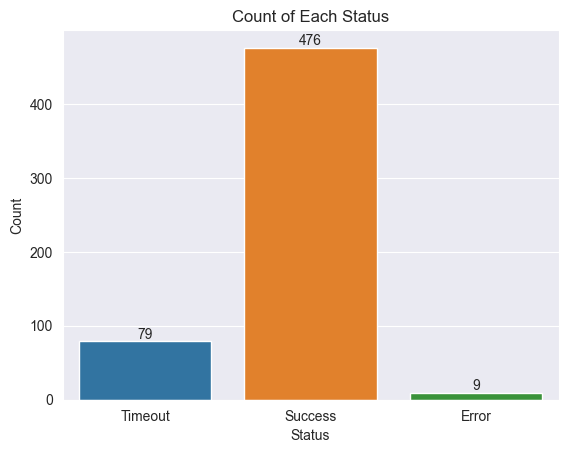

In [54]:
tmp_df = by_automaton_df.copy()
tmp_df["status"] =tmp_df["status"].astype(str)
ax = sns.countplot(data=tmp_df, x="status")
ax.bar_label(ax.containers[0])
plt.title('Count of Each Status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

## Load benchmarks by Formula

In [55]:
by_formula_loader = benchmark_loader(Algorithm.FORMULA, DEPENDENCIES_BY_FORMULA)
by_formula_df = pd.DataFrame([by_formula_loader(name) for name in get_all_benchmarks(DEPENDENCIES_BY_FORMULA)])
by_formula_df.head(5)

,id,name,algorithm,status,error,is_completed,total_time,total_output_vars,total_input_vars,total_dependents,dependency_ratio,is_automaton_built,automaton_build_duration,total_states,total_edges,total_pair_states,search_pair_states_duration,dependent_vars,independent_vars
0,379,Full_f1477cc5_1,Formula,Error,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,396,FelixSpecFixed4_dd3a27e1_2,Formula,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,115,TwoCountersRefined,Formula,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,545,ltl2dba25,Formula,Success,NaN,True,1872.0,1.0,3.0,0.0,0.0,True,9.0,11.0,33.0,NaN,NaN,[],[acc]
4,400,FelixSpecFixed4GuaranteesOnly_88f351a6_1,Formula,Timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
by_formula_df[by_formula_df["status"] != Status.SUCCESS][["algorithm", "status", "name", "error"]]

,algorithm,status,name,error
0,Formula,Error,Full_f1477cc5_1,
1,Formula,Timeout,FelixSpecFixed4_dd3a27e1_2,NaN
2,Formula,Timeout,TwoCountersRefined,NaN
4,Formula,Timeout,FelixSpecFixed4GuaranteesOnly_88f351a6_1,NaN
5,Formula,Error,Coffee_6479ef9a,Error occurred: std::bad_alloc\n
...,...,...,...,...
552,Formula,Error,TwoCountersDisButA4,
553,Formula,Timeout,Morning2s_42dc4fff_3,NaN
554,Formula,Timeout,AllLights_06e9cad4,NaN
558,Formula,Timeout,AllShades_66f450a4,NaN


### Analysing by Status

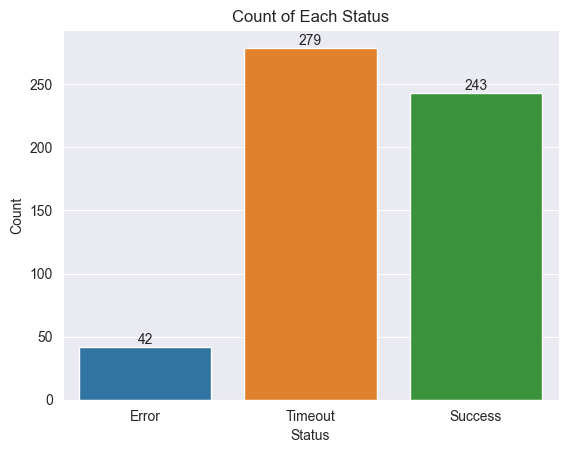

In [57]:
tmp_df = by_formula_df.copy()
tmp_df["status"] =tmp_df["status"].astype(str)
ax = sns.countplot(data=tmp_df, x="status")
ax.bar_label(ax.containers[0])
plt.title('Count of Each Status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

In [58]:
by_formula_df[by_formula_df["status"] == Status.ERROR]

,id,name,algorithm,status,error,is_completed,total_time,total_output_vars,total_input_vars,total_dependents,dependency_ratio,is_automaton_built,automaton_build_duration,total_states,total_edges,total_pair_states,search_pair_states_duration,dependent_vars,independent_vars
0,379,Full_f1477cc5_1,Formula,Error,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,284,Coffee_6479ef9a,Formula,Error,Error occurred: std::bad_alloc\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,380,Full_f1477cc5_2,Formula,Error,Error occurred: std::bad_alloc\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,77,Automata16S,Formula,Error,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,524,ltl2dba07,Formula,Error,Error occurred: std::bad_alloc\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,82,RotationCalculator,Formula,Error,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,359,Coffee_f1477cc5,Formula,Error,Error occurred: std::bad_alloc\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,460,Morning2s_d6c5ac79_1,Formula,Error,Error occurred: std::bad_alloc\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,231,Lights2_b02056d6,Formula,Error,Error occurred: std::bad_alloc\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,483,09,Formula,Error,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# By Formula vs By Automaton

In [59]:
common_fields = ["id","name", "status", "is_completed", "total_time", "dependent_vars"]

dependency_df = pd.merge(
    by_automaton_df[common_fields],
    by_formula_df[common_fields],
    on="name",
    suffixes=("_automaton", "_formula")
)
dependency_df

,id_automaton,name,status_automaton,is_completed_automaton,total_time_automaton,dependent_vars_automaton,id_formula,status_formula,is_completed_formula,total_time_formula,dependent_vars_formula
0,379,Full_f1477cc5_1,Timeout,NaN,NaN,NaN,379,Error,NaN,NaN,NaN
1,396,FelixSpecFixed4_dd3a27e1_2,Success,True,57.0,"[u0room29heating29ctrl0room29heating29ctrl, u0...",396,Timeout,NaN,NaN,NaN
2,115,TwoCountersRefined,Success,True,57.0,"[u0first2counter0first2counter, u0second2count...",115,Timeout,NaN,NaN,NaN
3,545,ltl2dba25,Success,True,8.0,[],545,Success,True,1872.0,[]
4,400,FelixSpecFixed4GuaranteesOnly_88f351a6_1,Success,True,1574453.0,[u0system29start2new2timer0system29start2new2t...,400,Timeout,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
559,244,CheckWarnlight_1cf58fc1,Success,True,8.0,[u02device29control02device29control],244,Success,True,263.0,[u02device29control02device29control]
560,497,arbiter_with_buffer,Success,True,5.0,[],497,Success,True,20.0,[]
561,35,OneCounterGuiA0,Success,True,61.0,"[u0button2down0button2down, u0button2up0button...",35,Timeout,NaN,NaN,NaN
562,182,lilydemo03,Success,True,9.0,[],182,Success,True,25863.0,[]


### Sanity Check - Same dependent variables

In [68]:
tmp_df = dependency_df[(dependency_df["is_completed_automaton"] == True) & (dependency_df["is_completed_formula"] == True)]
tmp_df[tmp_df["dependent_vars_formula"] != tmp_df["dependent_vars_automaton"]][["name", "dependent_vars_formula", "dependent_vars_automaton"]]
# tmp_df[tmp_df["id_automaton"] == "389"]

,name,dependent_vars_formula,dependent_vars_automaton
175,test2_f2774e0b_1,"[u0a0a, u0a0f1dc251b, u0b0b, u0c0c, u0c0f1dc31b]","[u0a0a, u0a0f1dc251b, u0b0b, u0c0c, u0c0f1dc31..."


# Dependency Prevelance

In [61]:
by_automaton_df = by_automaton_df[(by_automaton_df["is_completed"] == True) & (by_automaton_df["status"] == Status.SUCCESS)]
by_formula_df = by_formula_df[(by_formula_df["is_completed"] == True) & (by_formula_df["status"] == Status.SUCCESS)]

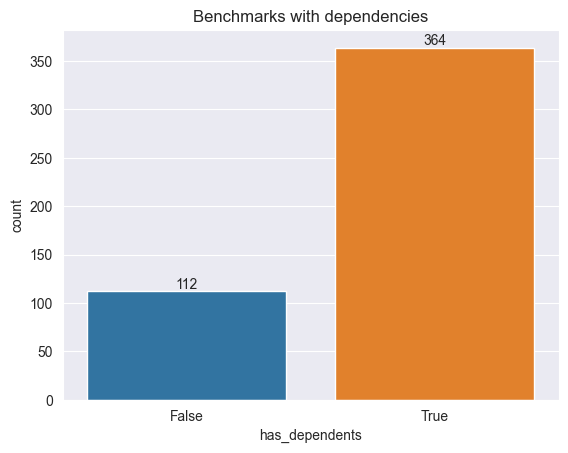

In [62]:
by_automaton_df["has_dependents"] = by_automaton_df["total_dependents"] > 0
ax = sns.countplot(data=by_automaton_df, x='has_dependents')
ax.bar_label(ax.containers[0]);
ax.set_title("Benchmarks with dependencies");

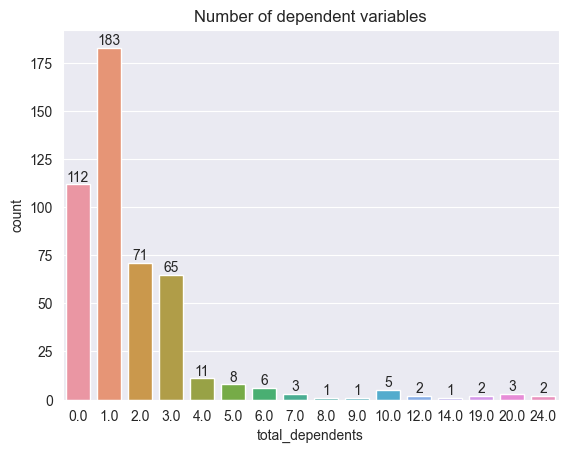

In [63]:
ax = sns.countplot(data=by_automaton_df, x='total_dependents')
ax.bar_label(ax.containers[0]);
ax.set_title("Number of dependent variables");

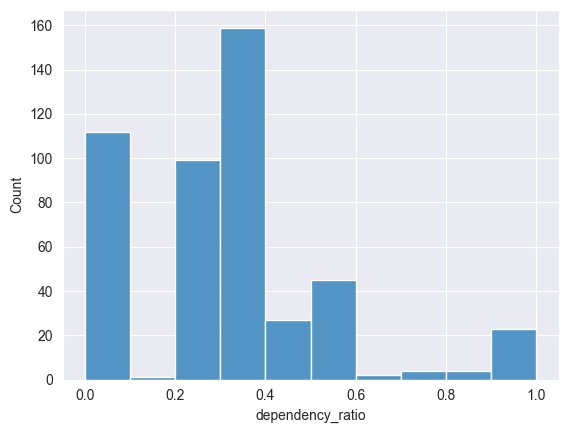

In [64]:
sns.histplot(data=by_automaton_df, x='dependency_ratio', bins=10);

In [65]:
dependency_df = pd.merge(
    by_automaton_df,
    by_formula_df,
    on="name",
    suffixes=("_automaton", "_formula")
)
dependency_df
dependency_df.to_csv('./dependency_df.csv')